In [42]:
%load_ext autoreload
%autoreload 2

Using fid n(z), which has 6 redshift bins


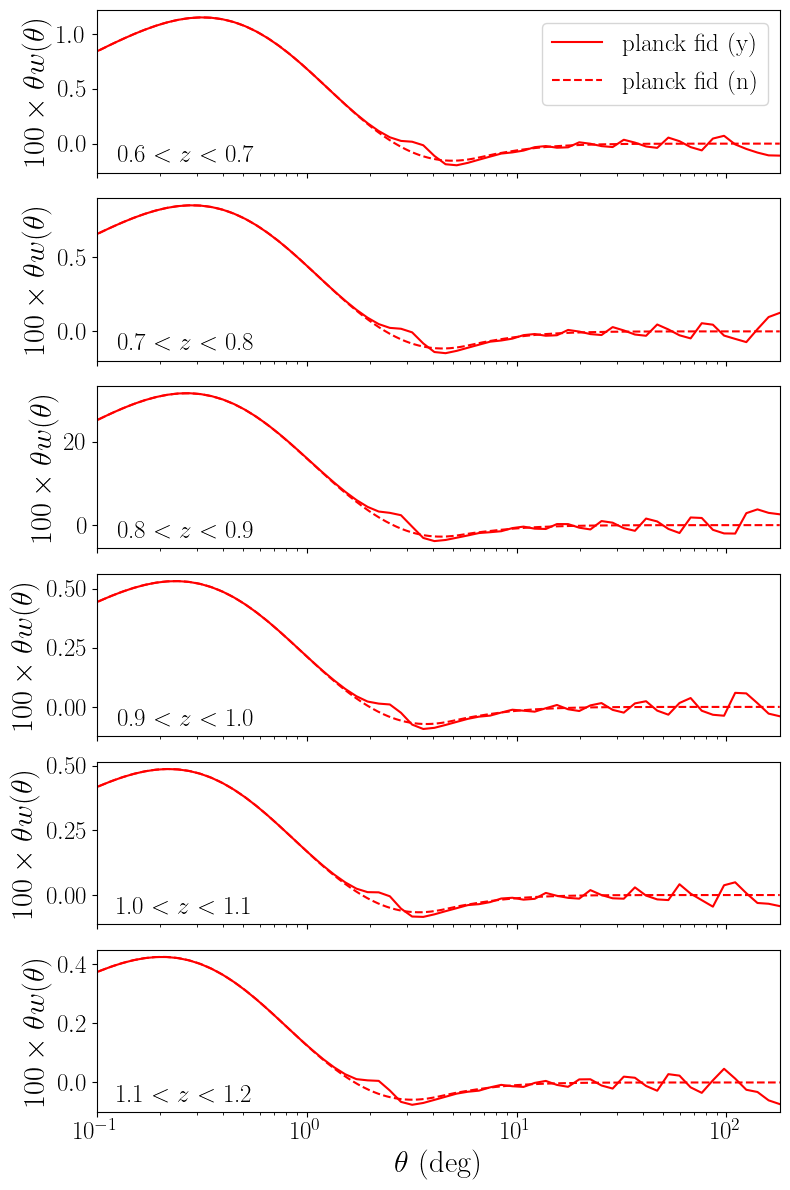

In [45]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
from utils import redshift_distributions
from utils_paths import path_template

def load_wtheta_template(cosmology_template, bin_z, nz_flag, include_wiggles='y'):
    include_wiggles = '' if include_wiggles == 'y' else '_nowiggles'
    wtheta_template = {}
    for component in ['bb', 'bf', 'ff']:
        loaddir = path_template(include_wiggles=include_wiggles, nz_flag=nz_flag, cosmology_template=cosmology_template, verbose=False)()
        file_path = os.path.join(loaddir, f'wtheta_{component}_bin{bin_z}.txt')
        data = np.loadtxt(file_path)
        theta = data[:, 0]
        wtheta_template[component] = data[:, 1]
    return theta, wtheta_template

galaxy_bias = {0: 1, 1: 1, 2: 10, 3: 1, 4: 1, 5: 1}

# cosmology_templates = ['mice', 'planck']
# nz_flags = ['fid']

# cosmology_templates = ['planck']
# nz_flags = ['fid', 'clusteringz']

cosmology_templates = ['planck']
nz_flags = ['fid']

colors = {
    ('mice', 'fid'): 'blue', 
    ('mice', 'clusteringz'): 'green', 
    ('planck', 'fid'): 'red', 
    ('planck', 'clusteringz'): 'orange'
}

nbins = {'fid': 6, 'clusteringz': 4}
linestyle = {'y': '-', 'n': '--'}

nbins_max = max(nbins[nz_flag] for nz_flag in nz_flags)
text_added = {bin_z: False for bin_z in range(nbins_max)}

fig, axs = plt.subplots(nbins_max, 1, figsize=(8, 2 * nbins_max), sharex=True)

for cosmology_template in cosmology_templates:
    for nz_flag in nz_flags:
        z_edges = redshift_distributions(nz_flag).z_edges
        color = colors[(cosmology_template, nz_flag)]
        
        wtheta = {}
        wtheta_bb = {}
        wtheta_bf = {}
        wtheta_ff = {}

        for bin_z in range(nbins[nz_flag]):
            ax = axs[bin_z]
            
            for include_wiggles in ['y', 'n']:
                label = cosmology_template + ' ' + nz_flag + ' (' + include_wiggles + ')'
                
                theta, wtheta_template = load_wtheta_template(cosmology_template, bin_z, nz_flag, include_wiggles)
                
                wtheta_bb[bin_z] = wtheta_template['bb']
                wtheta_bf[bin_z] = wtheta_template['bf']
                wtheta_ff[bin_z] = wtheta_template['ff']
                
                wtheta[bin_z] = galaxy_bias[bin_z] ** 2 * wtheta_bb[bin_z] + galaxy_bias[bin_z] * wtheta_bf[bin_z] + wtheta_ff[bin_z]
                
                ax.semilogx(theta * 180 / np.pi, 100 * (theta * 180 / np.pi) * wtheta[bin_z], label=label, color=color, linestyle=linestyle[include_wiggles])

            z_edge = z_edges[bin_z]
            if bin_z == nbins_max - 1:
                ax.set_xlabel(r'$\theta$ (deg)', fontsize=22)
            ax.set_ylabel(r'$100 \times \theta w(\theta)$', fontsize=22)
            ax.set_xlim([10**-1, 180])
            ax.tick_params(axis='x', labelsize=18)
            ax.tick_params(axis='y', labelsize=18)

            if nbins[nz_flag] == nbins_max and not text_added[bin_z]:
                ax.text(0.13, 0.1, f'{z_edge[0]} $< z <$ {z_edge[1]}', ha='center', va='center', transform=ax.transAxes, fontsize=18)
                text_added[bin_z] = True

        # if cosmology_template == cosmology_templates[0]:  # Add legend only to the first cosmology template
        axs[0].legend(loc='upper right', fontsize=18, ncol=len(cosmology_templates) * len(nz_flags))

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
from utils import redshift_distributions
from utils_paths import path_template

def load_wtheta_template(cosmology_template, bin_z, nz_flag, include_wiggles='y'):
    include_wiggles = '' if include_wiggles == 'y' else '_nowiggles'
    wtheta_template = {}
    for component in ['bb', 'bf', 'ff']:
        loaddir = path_template(include_wiggles=include_wiggles, nz_flag=nz_flag, cosmology_template=cosmology_template, verbose=False)()
        file_path = os.path.join(loaddir, f'wtheta_{component}_bin{bin_z}.txt')
        data = np.loadtxt(file_path)
        theta = data[:, 0]
        wtheta_template[component] = data[:, 1]
    return theta, wtheta_template

galaxy_bias = {0: 1, 1: 1, 2: 10, 3: 1, 4: 1, 5: 1}

cosmology_templates = ['mice', 'planck']
# cosmology_templates = ['planck']
nz_flags = ['fid', 'clusteringz']
nz_flags = ['fid']

colors = {'fid': 'blue', 'clusteringz': 'red'}
nbins = {'fid': 6, 'clusteringz': 4}
linestyle = {'y': '-', 'n': '--'}

nbins_max = max(nbins[nz_flag] for nz_flag in nz_flags)
text_added = {bin_z: False for bin_z in range(nbins_max)}

fig, axs = plt.subplots(nbins_max, 1, figsize=(8, 2 * nbins_max), sharex=True)

for cosmology_template in cosmology_templates:
    for nz_flag in nz_flags:
        z_edges = redshift_distributions(nz_flag).z_edges
        color = colors[nz_flag]
        
        wtheta = {}
        wtheta_bb = {}
        wtheta_bf = {}
        wtheta_ff = {}

        for bin_z in range(nbins[nz_flag]):
            ax = axs[bin_z]
            
            for include_wiggles in ['y', 'n']:
                label = cosmology_template + ' ' + nz_flag + ' (' + include_wiggles + ')'
                
                theta, wtheta_template = load_wtheta_template(cosmology_template, bin_z, nz_flag, include_wiggles)
                
                wtheta_bb[bin_z] = wtheta_template['bb']
                wtheta_bf[bin_z] = wtheta_template['bf']
                wtheta_ff[bin_z] = wtheta_template['ff']
                
                wtheta[bin_z] = galaxy_bias[bin_z] ** 2 * wtheta_bb[bin_z] + galaxy_bias[bin_z] * wtheta_bf[bin_z] + wtheta_ff[bin_z]
                
                ax.semilogx(theta * 180 / np.pi, 100 * (theta * 180 / np.pi) * wtheta[bin_z], label=label, color=color, linestyle=linestyle[include_wiggles])

            z_edge = z_edges[bin_z]
            if bin_z == nbins_max - 1:  # Only set xlabel on the last subplot
                ax.set_xlabel(r'$\theta$ (deg)', fontsize=22)
            ax.set_ylabel(r'$100 \times \theta w(\theta)$', fontsize=22)
            ax.set_xlim([10**-1, 180])
            ax.tick_params(axis='x', labelsize=18)
            ax.tick_params(axis='y', labelsize=18)

            if nbins[nz_flag] == nbins_max and not text_added[bin_z]:
                ax.text(0.13, 0.1, f'{z_edge[0]} $< z <$ {z_edge[1]}', ha='center', va='center', transform=ax.transAxes, fontsize=18)
                text_added[bin_z] = True

        if nz_flag == nz_flags[-1]:
            axs[0].legend(loc='upper right', fontsize=18, ncol=len(nz_flags))

plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# plt.rcParams["text.usetex"] = True
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
# from utils import redshift_distributions
# from utils_paths import path_template

# def load_wtheta_template(cosmology_template, bin_z, nz_flag, include_wiggles='y'):
#     include_wiggles = '' if include_wiggles == 'y' else '_nowiggles'
#     wtheta_template = {}
#     for component in ['bb', 'bf', 'ff']:
#         loaddir = path_template(include_wiggles=include_wiggles, nz_flag=nz_flag, cosmology_template=cosmology_template, verbose=False)()
#         file_path = os.path.join(loaddir, f'wtheta_{component}_bin{bin_z}.txt')
#         data = np.loadtxt(file_path)
#         theta = data[:, 0]
#         wtheta_template[component] = data[:, 1]
#     return theta, wtheta_template

# galaxy_bias = {0: 1, 1: 1, 2: 10, 3: 1, 4: 1, 5: 1}

# cosmology_templates = ['mice']
# cosmology_templates = ['planck']
# nz_flags = ['fid', 'clusteringz']
# # nz_flags = ['clusteringz']

# colors = {'fid': 'blue', 'clusteringz': 'red'}
# nbins = {'fid': 6, 'clusteringz': 4}
# linestyle = {'y': '-', 'n': '--'}

# nbins_max = max(nbins[nz_flag] for nz_flag in nz_flags)

# fig, axs = plt.subplots(nbins_max, 1, figsize=(8, 2 * nbins_max), sharex=True)

# # Loop through cosmology templates and nz_flags
# for cosmology_template in cosmology_templates:
#     for nz_flag in nz_flags:
#         z_edges = redshift_distributions(nz_flag).z_edges
#         color = colors[nz_flag]
        
#         wtheta = {}
#         wtheta_bb = {}
#         wtheta_bf = {}
#         wtheta_ff = {}

#         # Loop through bins
#         for bin_z in range(nbins[nz_flag]):
#             ax = axs[bin_z]  # Access each subplot
            
#             for include_wiggles in ['y', 'n']:
#                 label = cosmology_template + ' ' + nz_flag + ' (' + include_wiggles + ')'
                
#                 # Load the wtheta template
#                 theta, wtheta_template = load_wtheta_template(cosmology_template, bin_z, nz_flag, include_wiggles)
                
#                 # Store wtheta components for later use
#                 wtheta_bb[bin_z] = wtheta_template['bb']
#                 wtheta_bf[bin_z] = wtheta_template['bf']
#                 wtheta_ff[bin_z] = wtheta_template['ff']
                
#                 # Calculate the combined wtheta
#                 wtheta[bin_z] = galaxy_bias[bin_z] ** 2 * wtheta_bb[bin_z] + galaxy_bias[bin_z] * wtheta_bf[bin_z] + wtheta_ff[bin_z]
                
#                 # Plot on the respective ax
#                 ax.semilogx(theta * 180 / np.pi, 100 * (theta * 180 / np.pi) * wtheta[bin_z], label=label, color=color, linestyle=linestyle[include_wiggles])

#             # Set labels, limits, and other styling
#             z_edge = z_edges[bin_z]
#             if bin_z == nbins_max - 1:  # Only set xlabel on the last subplot
#                 ax.set_xlabel(r'$\theta$ (deg)', fontsize=22)
#             ax.set_ylabel(r'$100 \times \theta w(\theta)$', fontsize=22)
#             ax.set_xlim([10**-1, 180])
#             ax.tick_params(axis='x', labelsize=18)
#             ax.tick_params(axis='y', labelsize=18)
#             ax.text(0.13, 0.1, f'{z_edge[0]} $< z <$ {z_edge[1]}', ha='center', va='center', transform=ax.transAxes, fontsize=18)
#             ax.legend(loc='upper right', fontsize=18)

# # Adjust layout for better spacing
# plt.tight_layout()


In [ ]:
int(5/2)

In [ ]:
nbins[nz_flags]